# Estimating the Tail of the Distribution of Cryptocurrency Returns

**John Stachurski and Quentin Batista**

A well-known phenomenon in Economics is that financial returns tend to have a fat-tailed distribution. Broadly speaking, this means that the probability of observing an extreme event under this distribution is larger than it is for a normal distribution with the same mean and variance. This empirical power law has been well-documented for a wide range of securities in many different countries. In this notebook, we attempt to determine whether such a power law holds for cryptocurrencies by estimating the distribution tail of their returns.

## Getting the Data

We obtain data on cryptocurrency prices from Poloniex, a US-based cryptocurrency exchange platform. The data is available at different frequencies. We choose the highest frequency (5-minute interval) in order to maximize the number of data points. Below is a list of the different currencies we analyze:

- BTC: Bitcoin
- ETH: Etherum
- BCH: Bitcoin Cash 
- XRP: Ripple
- ETC: Etherum Classic
- STR: Stellar
- XMR: Monero
- LTC: Litecoin
- REP: Augur
- DASH: Dash
- NXT: NXT 
- ZEC: Zcash

In [1]:
import pandas as pd
import numpy as np

def get_data(symbol, frequency):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start=0'
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

tickers = ['BTC', 'ETC', 'XRP', 'ETH', 'XMR', 'LTC', 'STR', 'BCH', 'NXT', 'ZEC', 'DASH', 'REP']
tickers = ['USDT_' + ticker for ticker in tickers]

In [3]:
# Sometimes fails -- run again if it does

prices_df = pd.DataFrame()

for ticker in tickers:
    prices_df = prices_df.join(get_data(ticker, 300)['close'].rename(ticker), how='outer')

We use the first order difference of the natural log of prices as a measure of return.

In [4]:
# Log difference
five_min_returns = np.log(prices_df)
five_min_returns = five_min_returns-five_min_returns.shift(1)

## Data Visualization

We begin by visualizing the data to find patterns suggesting the presence of heavy tails. Using kernel density estimates, we plot the distribution of the returns.

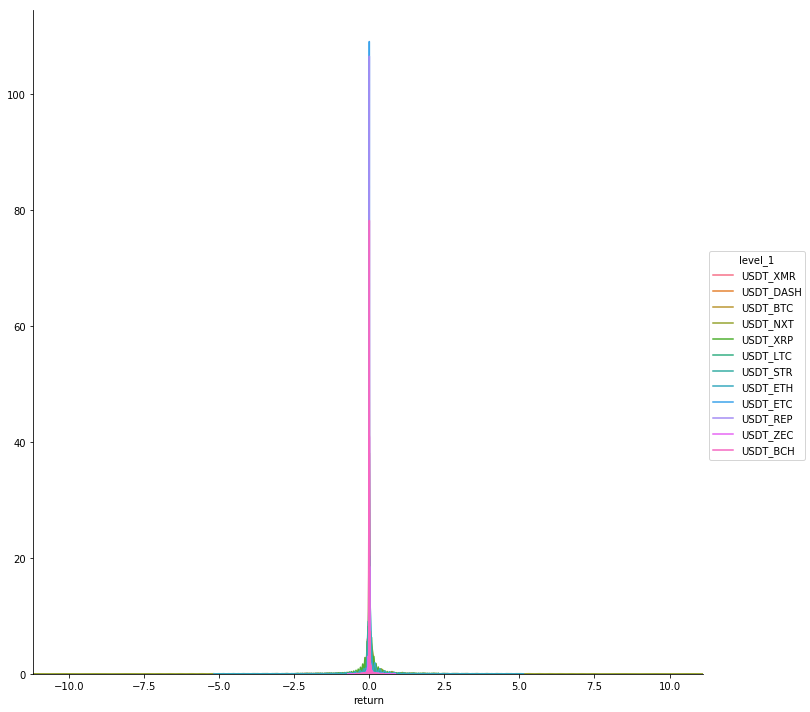

In [5]:
import seaborn as sns
density_df = pd.DataFrame(five_min_returns.stack(), columns=['return']).reset_index()

%matplotlib inline

kde_plot = (sns.FacetGrid(density_df,
                     hue='level_1',
                     size=10,
                     xlim=(min(density_df['return']), max(density_df['return']))).map(sns.kdeplot, 'return').add_legend())

This plot suggests that returns can sometimes take on very extreme values as evidenced by the heavy tails of the estimated distribution. However, not only is it difficult to differentiate between currencies in this plot, it is also hard to see what exactly happens in the tails. To better understand this pattern, we plot the returns over time with some deviation statistics.

USDT_BTC


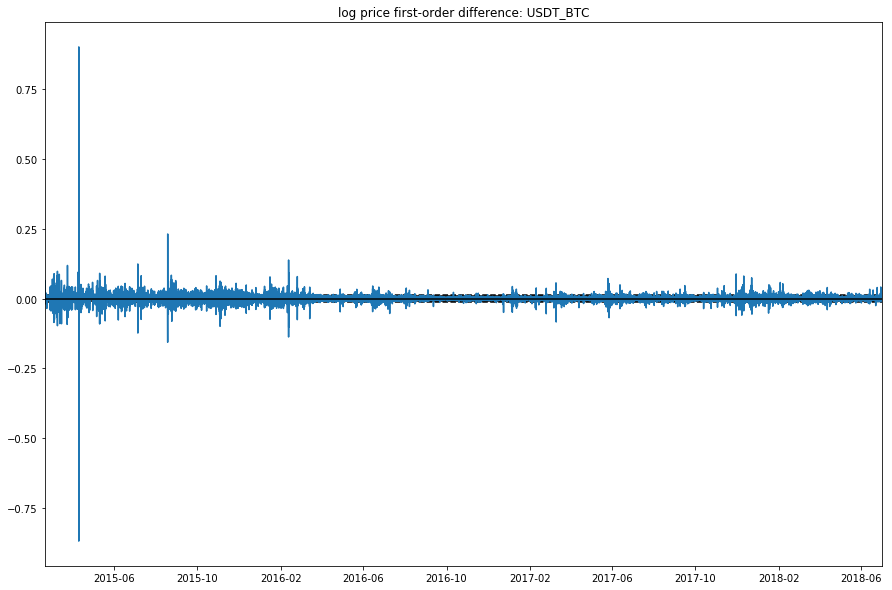

1.44% of observations are greater than 3 standard deviations from the mean
0.76% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 198.39 deviations from the mean
USDT_ETC


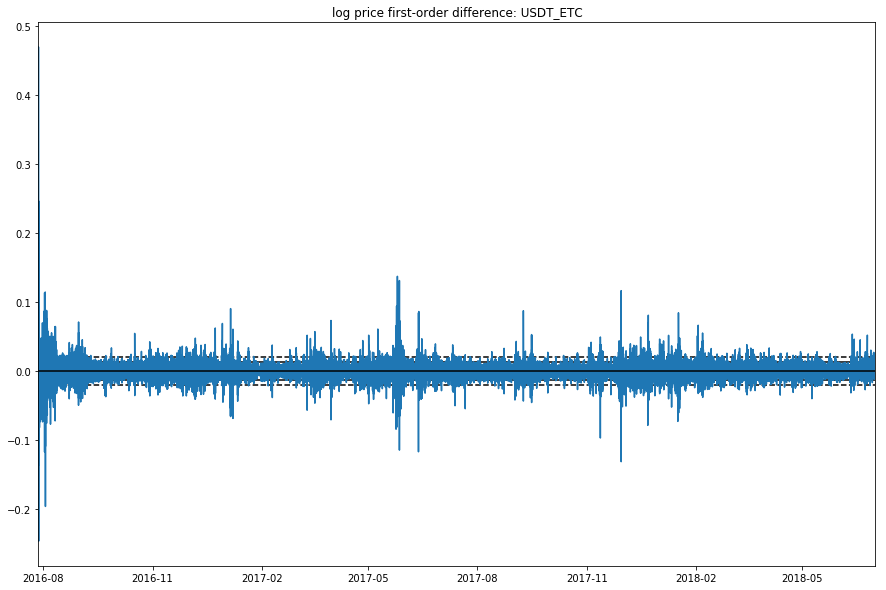

1.6% of observations are greater than 3 standard deviations from the mean
0.69% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 70.12 deviations from the mean
USDT_XRP


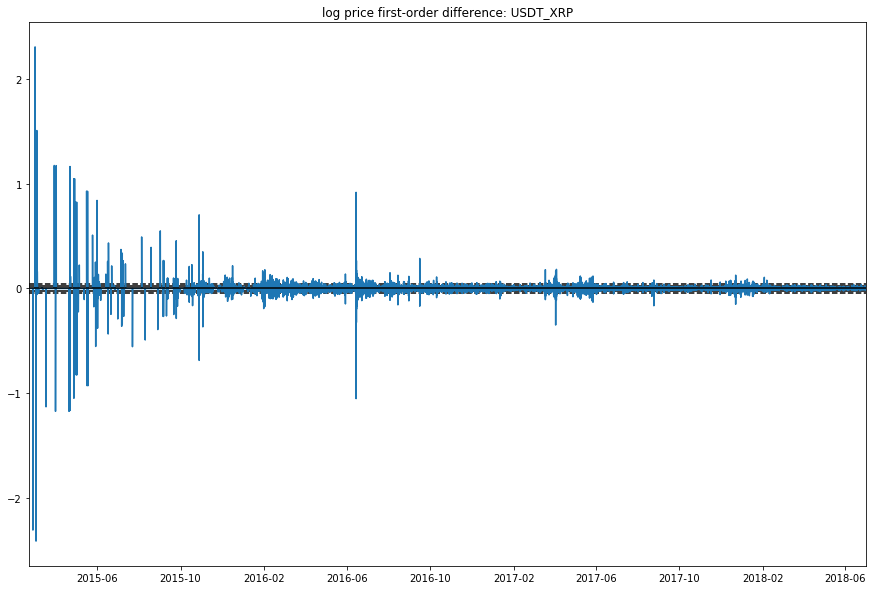

0.42% of observations are greater than 3 standard deviations from the mean
0.22% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 174.37 deviations from the mean
USDT_ETH


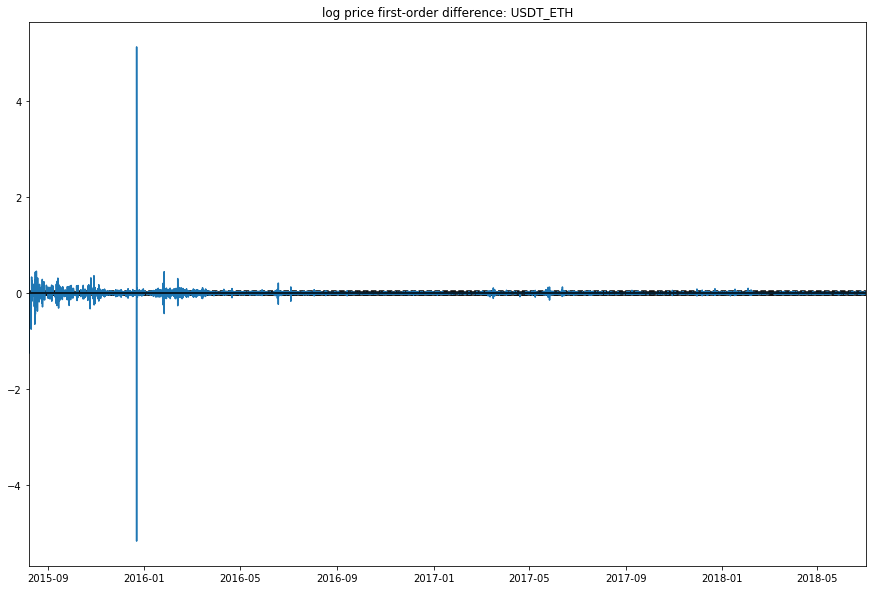

0.31% of observations are greater than 3 standard deviations from the mean
0.17% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 330.39 deviations from the mean
USDT_XMR


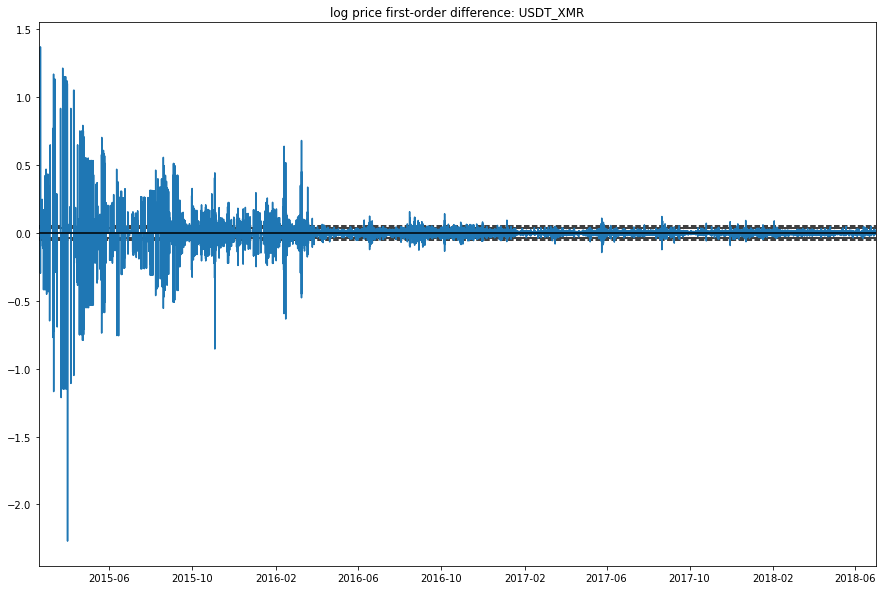

0.38% of observations are greater than 3 standard deviations from the mean
0.27% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 131.73 deviations from the mean
USDT_LTC


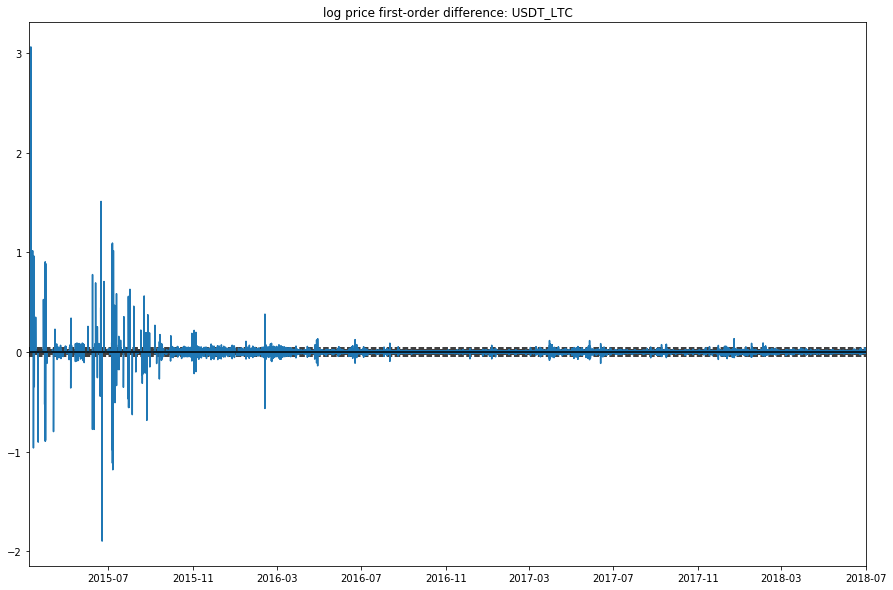

0.26% of observations are greater than 3 standard deviations from the mean
0.13% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 250.93 deviations from the mean
USDT_STR


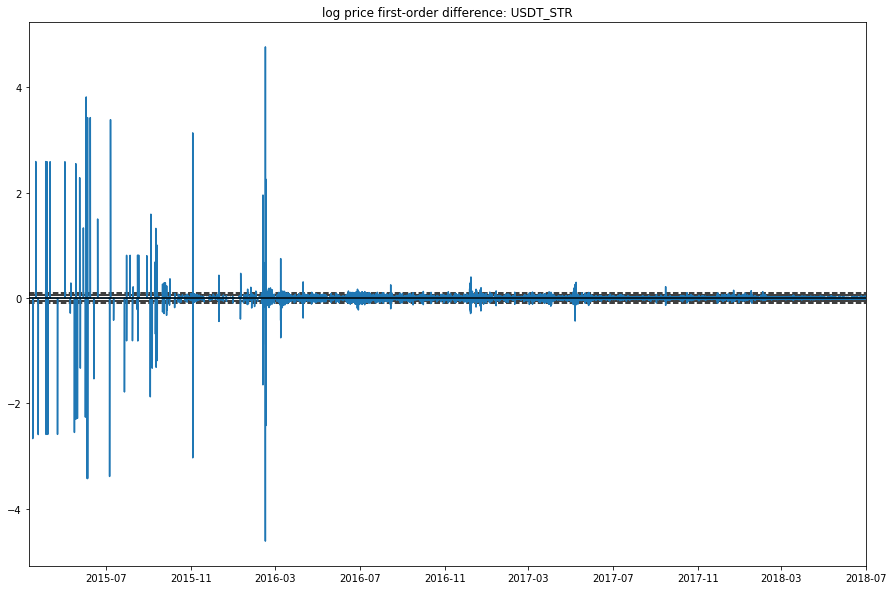

0.11% of observations are greater than 3 standard deviations from the mean
0.06% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 154.05 deviations from the mean
USDT_BCH


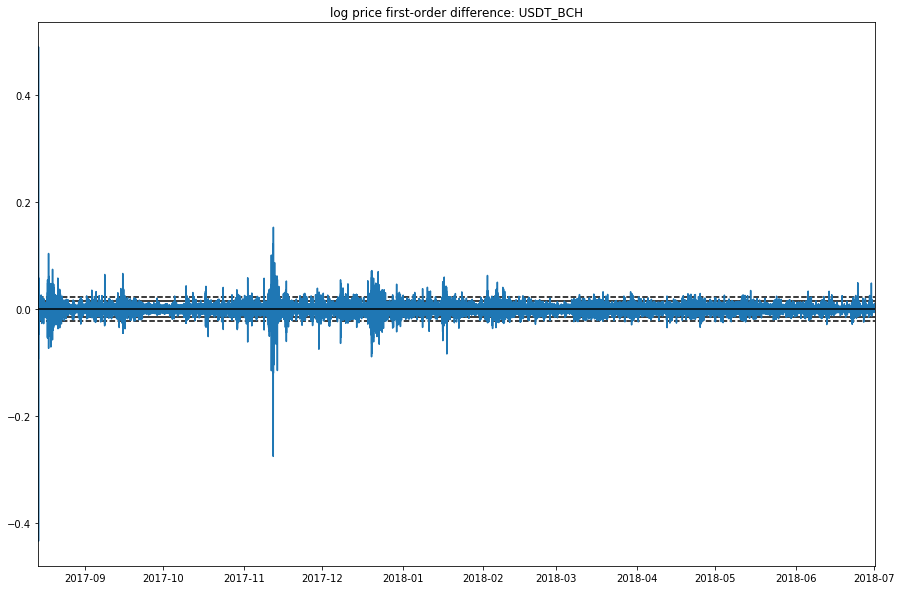

1.38% of observations are greater than 3 standard deviations from the mean
0.6% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 66.72 deviations from the mean
USDT_NXT


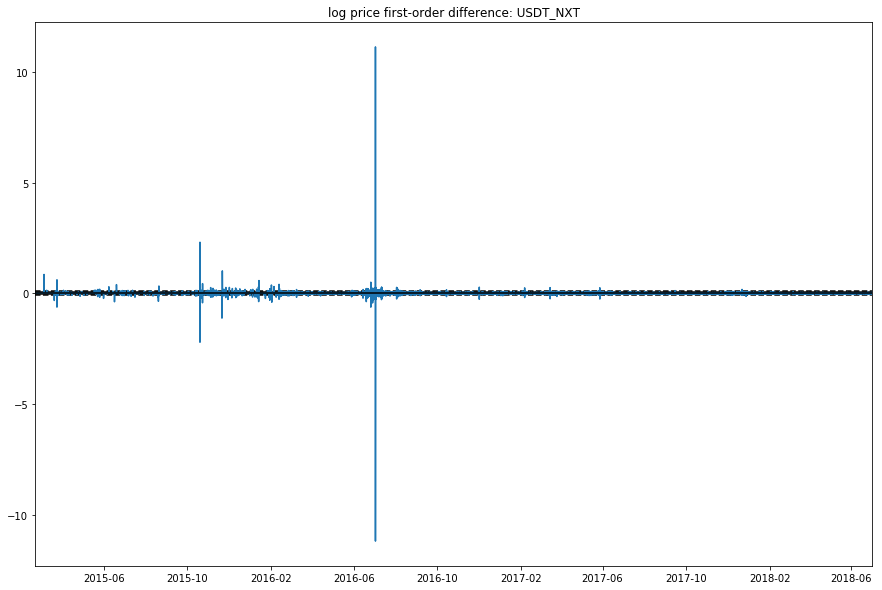

0.15% of observations are greater than 3 standard deviations from the mean
0.09% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 387.42 deviations from the mean
USDT_ZEC


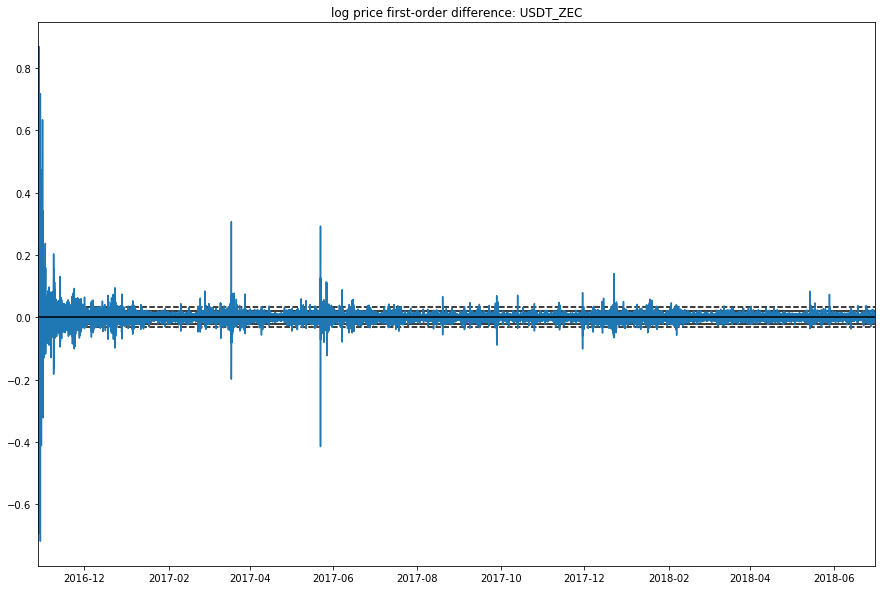

0.94% of observations are greater than 3 standard deviations from the mean
0.49% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 80.21 deviations from the mean
USDT_DASH


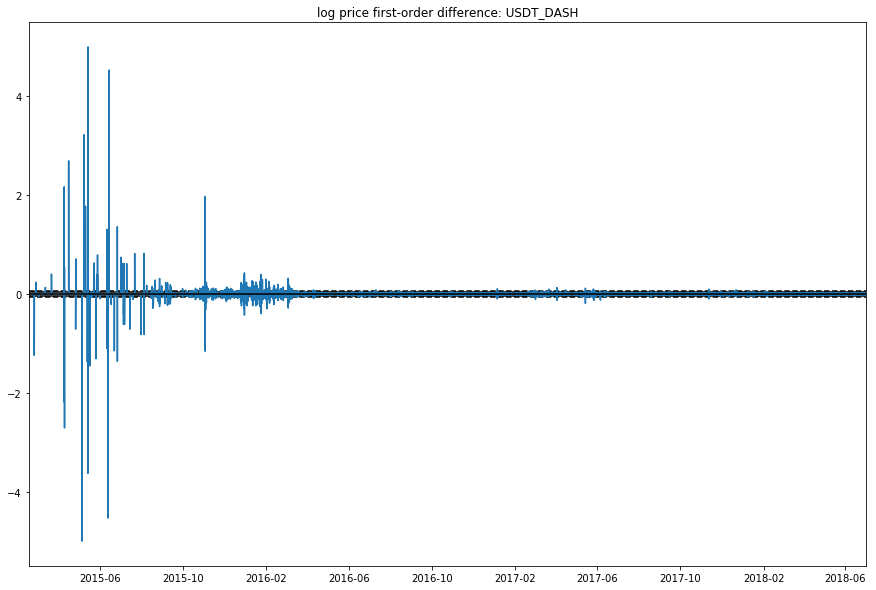

0.11% of observations are greater than 3 standard deviations from the mean
0.08% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 216.44 deviations from the mean
USDT_REP


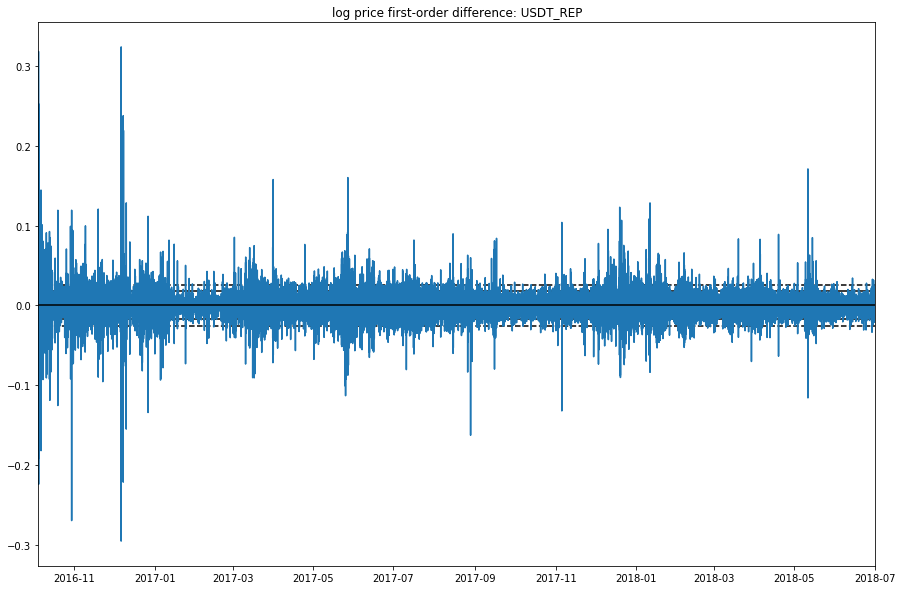

1.82% of observations are greater than 3 standard deviations from the mean
0.8% of observations are greater than 4 standard deviations from the mean
The maximum deviation is 37.28 deviations from the mean


In [6]:
import matplotlib.pyplot as plt

def find_fattails(data, name):
    series = data[data.notnull()]         # Remove null entries from series
    std = series.std()                            # Find standard deviation
    mean = series.mean()                    # Find mean
    
    print(name)
    
    plt.figure(figsize=(15, 10))
    plt.axhline(mean + std * 2, c='k')
    plt.axhline(mean + std * 3, c='k', ls='--')
    plt.axhline(mean - std * 2, c='k')
    plt.axhline(mean - std * 3, c='k', ls='--')
    plt.plot(series)
    plt.axhline(mean, c='k')
    plt.title('log price first-order difference: ' + name)
    plt.xlim(min(series.index), max(series.index))
    plt.show()
    
    for n in (3, 4):
        outliers = series[(series > mean + std * n) | (series < mean - std * n)]
        outliers_pct = len(outliers) / len(series) * 100
        print(str(round(outliers_pct, 2)) + "% of observations are greater than " + str(n) + " standard deviations from the mean")
    
    max_dev = (series.abs().max() - mean)/std
    print("The maximum deviation is " + str(round(max_dev, 2)) + " deviations from the mean")
    
for ticker in tickers:
    find_fattails(five_min_returns[ticker], ticker)

These plots confirm our previous observation as some observations are extremely far away from the mean. 

## Tail Index Estimation

One of the ways to measure the degree of heavy-tailedness of a distribution is to use a tail index which characterizes the rate of power decay of the distribution tails. A low index value corresponds to a high probability mass in the tails. A popular way of estimating these indices is to use an OLS log-log rank-size regression. With optimal shift, the process is as follows:

1. Arrange the absolute values of returns in descending order and keep track of their rank.  
2. Choose a truncation level $T$ (typically 5% or 10%) and discard the $1-T$ smallest absolute returns.  
3. Estimate $\mathrm{ln}\left(t-\frac{1}{2}\right)=\alpha-\beta\mathrm{ln}\left(\left|r\right|_{\left(t\right)}\right)$ using OLS where $\left|r\right|_{\left(t\right)}$ is the $t$th highest absolute return.

The estimated value of $\beta$ is the estimate for the tail index.

First, we create a log-log rank-size scatter plot to determine whether the linear model is appropriate. Then, we carry out the regressions using the `statsmodels` package.

In [7]:
abs_five_min_returns = abs(five_min_returns)

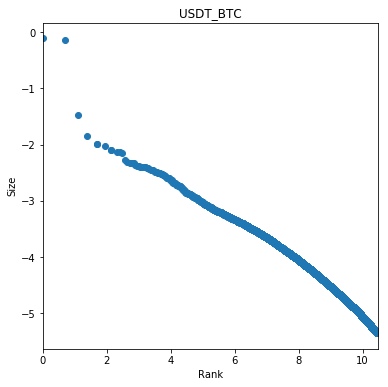

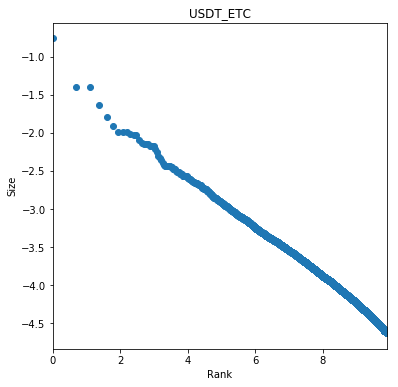

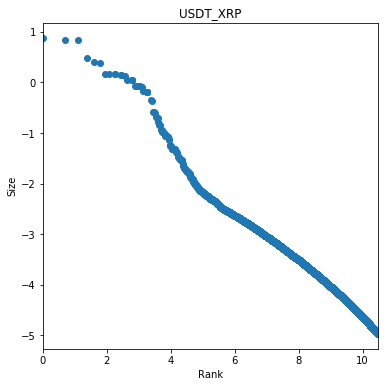

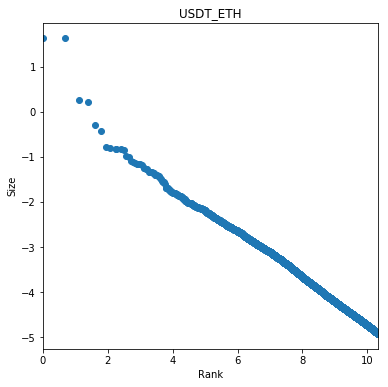

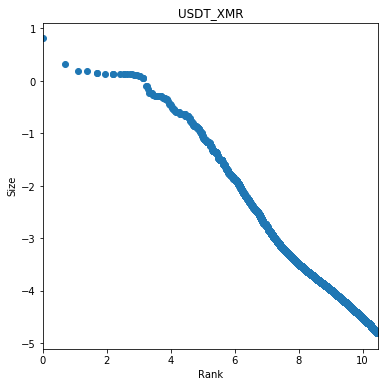

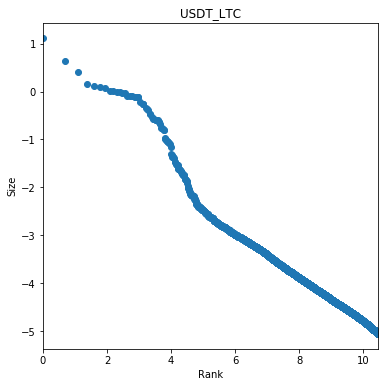

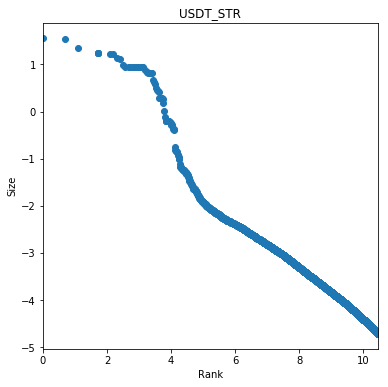

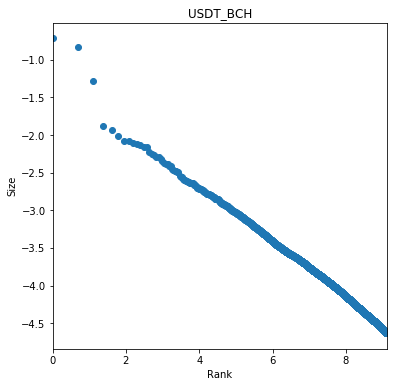

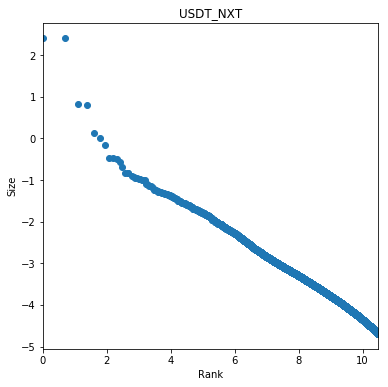

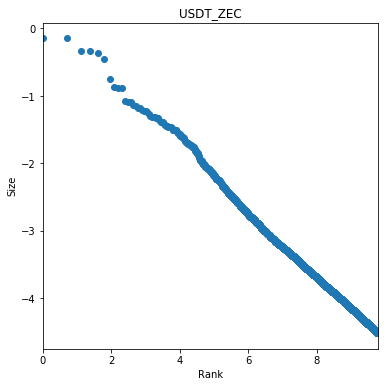

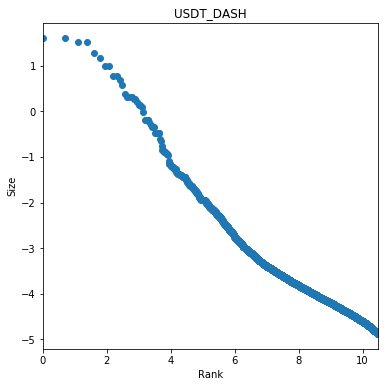

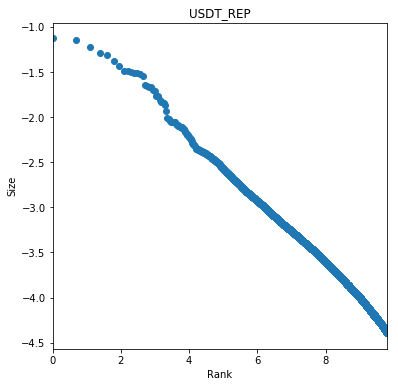

In [8]:
quantile = 0.9

for ticker in tickers: 
    truncation_level = abs_five_min_returns[ticker].quantile(quantile)
    condition = abs_five_min_returns[ticker] > truncation_level
    x = np.log(abs_five_min_returns.rank(ascending=False)[condition][ticker])
    y = np.log(abs_five_min_returns[condition][ticker])
    
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y)
    plt.title(ticker)
    plt.xlabel('Rank')
    plt.ylabel('Size')
    plt.xlim(min(x), max(x))
    plt.show()

A linear model seems to provide a reasonable approximation to the relationship in the data despite the fact that some of the highest ranked observations are often outliers.

In [9]:
import statsmodels.api as sm

def log_log_rank_size_reg(ticker, quantile, n):
    truncation_level = abs_five_min_returns[ticker].quantile(quantile)
    condition = abs_five_min_returns[ticker] > truncation_level

    Y = np.log(abs_five_min_returns.rank(ascending=False)[condition][ticker] - 1/2)
    X = -np.log(abs_five_min_returns[condition][ticker])
    X = sm.add_constant(X)

    model = sm.OLS(Y,X)
    results = model.fit()

    se = np.sqrt(2/n)*results.params[1]

    output = 'Top ' + str(round(100-quantile*100)) + '%  --  ' +  'Estimated Tail Index: ' + str(round(results.params[1], 2)) + (
    '  --  95% Confidence Interval: [' + str(round(results.params[1]-1.96*se, 2)) + ', ' + str(round(results.params[1]+1.96*se, 2)) + ']')
    
    print(output)

/Users/QBatista/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
for ticker in tickers:
    print(ticker)
    n = abs_five_min_returns[ticker].dropna().shape[0]
    print("total number of observations: " + str(n))
    log_log_rank_size_reg(ticker, 0.9, n)
    log_log_rank_size_reg(ticker, 0.95, n)
    print("")

USDT_BTC
total number of observations: 353577
Top 10%  --  Estimated Tail Index: 2.07  --  95% Confidence Interval: [2.06, 2.08]
Top 5%  --  Estimated Tail Index: 2.3  --  95% Confidence Interval: [2.29, 2.31]

USDT_ETC
total number of observations: 202586
Top 10%  --  Estimated Tail Index: 2.76  --  95% Confidence Interval: [2.74, 2.78]
Top 5%  --  Estimated Tail Index: 2.97  --  95% Confidence Interval: [2.95, 2.99]

USDT_XRP
total number of observations: 353277
Top 10%  --  Estimated Tail Index: 1.79  --  95% Confidence Interval: [1.78, 1.79]
Top 5%  --  Estimated Tail Index: 1.9  --  95% Confidence Interval: [1.89, 1.91]

USDT_ETH
total number of observations: 304772
Top 10%  --  Estimated Tail Index: 1.89  --  95% Confidence Interval: [1.88, 1.9]
Top 5%  --  Estimated Tail Index: 1.9  --  95% Confidence Interval: [1.89, 1.91]

USDT_XMR
total number of observations: 354345
Top 10%  --  Estimated Tail Index: 1.67  --  95% Confidence Interval: [1.67, 1.68]
Top 5%  --  Estimated Tail 

All our estimates fall into the $\left[1.5,3\right]$ interval, which corresponds to a relatively high degree of heavy-tailedness.

To put this in context, we carry out the same process on S&P 500 daily returns.

In [11]:
import pandas_datareader as pdr
import datetime

start = datetime.datetime(1993, 2, 1)
sp_prices = pdr.data.DataReader('SPY', data_source='yahoo', start=start)['Adj Close']
sp_returns = (np.log(sp_prices) - np.log(sp_prices).shift(1)).dropna()

n = sp_returns.shape[0]
quantile = 0.95

truncation_level = sp_returns.quantile(quantile)
condition = sp_returns > truncation_level

Y = np.log(sp_returns.rank(ascending=False)[condition] - 1/2)
X = -np.log(sp_returns[condition])
X = sm.add_constant(X)

model = sm.OLS(Y,X)
results = model.fit()

se = np.sqrt(2/n)*results.params[1]

output = 'Top ' + str(round(100-quantile*100)) + '%  --  ' +  'Estimated Tail Index: ' + str(round(results.params[1], 2)) + (
'  --  95% Confidence Interval: [' + str(round(results.params[1]-1.96*se, 2)) + ', ' + str(round(results.params[1]+1.96*se, 2)) + ']')

print(output)

Top 5%  --  Estimated Tail Index: 2.91  --  95% Confidence Interval: [2.81, 3.02]


The estimated tail index is higher than that of most cryptocurrencies, which suggests that the distribution of cryptocurrency returns have fatter tails than the distribution of returns for the average U.S. based large-cap company.

## References

[1] Andrei Ankudinov, Rustam Ibragimov, and Oleg Lebedev. Heavy tails and asymmetry of returns in the russian stock market. Emerging Markets Review, 32:200–219, 2017.  
[2] Thomas Lux and Simone Alfarano. Financial power laws: Empirical evidence,models, and mechanisms. Chaos, Solitons & Fractals, 88:3–18, 2016.